# Morphological operations on label images

In this notebook we will demonstrate how to fine-tune outlines of labels by smoothing them. The operation is related to erosion and dilation of labels. It is however not exactly what opening does. It differs by not leaving gaps behind but filling them with the closes labels.

See also
* [Twitter discussion about naming 'smooth_labels'](https://twitter.com/haesleinhuepf/status/1492215964305436673)

In [5]:
import numpy as np
import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import matplotlib.pyplot as plt
from skimage.data import cells3d
import stackview

A potential use-case is fine-tuning cell segmentation results. Thus, we take a look at a segmentation of cells based on membranes.

StackViewNDArray([[4496, 5212, 6863, ..., 2917, 2680, 2642],
                  [4533, 5146, 7555, ..., 2843, 2857, 2748],
                  [4640, 6082, 8452, ..., 3372, 3039, 3128],
                  ...,
                  [1339, 1403, 1359, ..., 4458, 4314, 4795],
                  [1473, 1560, 1622, ..., 3967, 4531, 4204],
                  [1380, 1368, 1649, ..., 3091, 3558, 3682]], dtype=uint16)
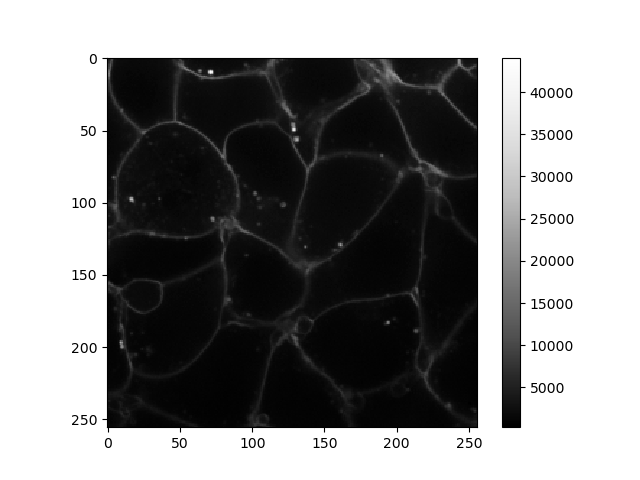
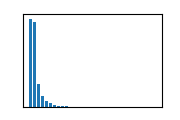

In [4]:
membranes = cells3d()[30,0]
stackview.insight(membranes)

StackViewNDArray([[ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  ...,
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27]])
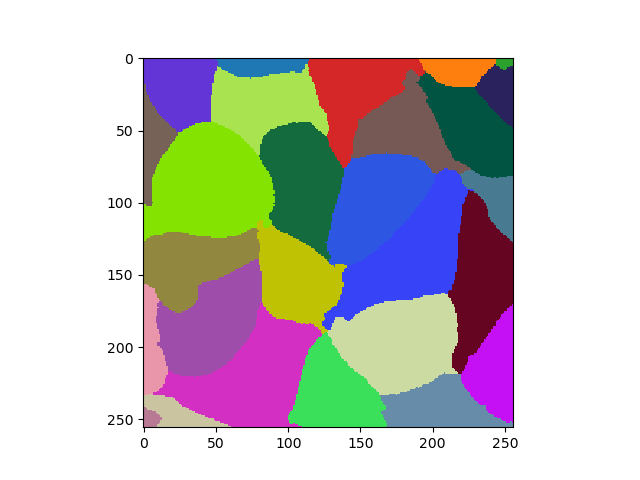

In [6]:
labels = nsbatwm.local_minima_seeded_watershed(membranes)
labels

## Label erosion
Label erosion works exactly like erosion on binary images. The only difference is that it works on a per-label basis. Each label is eroded independently from the others introducing black (`0`) regions between them.

cl.OCLArray([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  0,  0,  0],
       [ 5,  5,  5, ...,  0,  0,  0],
       ...,
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0]], dtype=uint32)
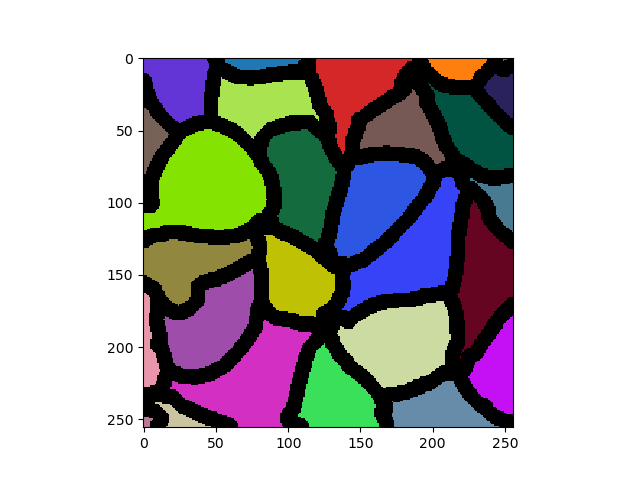

In [8]:
eroded_labels = cle.erode_labels(labels, radius=5)

eroded_labels

## Label dilation
To close these black gaps again, we can apply label dilation. It is different from binary image dilation as labels cannot overwrite each other. When the gap between them is closed, the labels stop growing.

cl.OCLArray([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0]], dtype=uint32)
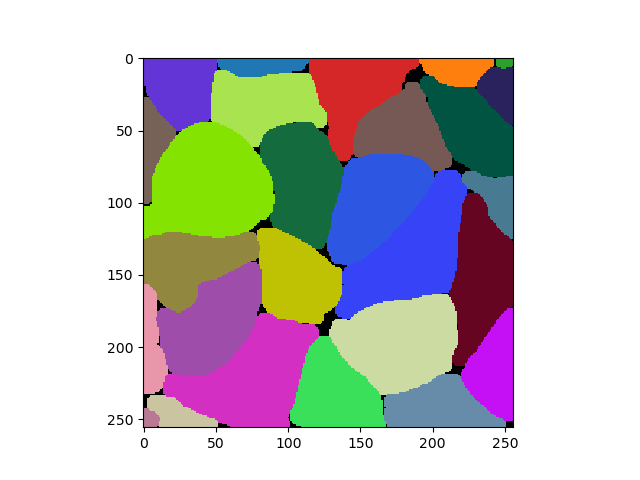

In [10]:
dilated_labels = cle.dilate_labels(eroded_labels, radius=5)
dilated_labels

## Label opening and closing
Combining label erosion and dilation as shown above can also be done in one shot using label closing and opening.

cl.OCLArray([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0],
       [24, 24, 24, ...,  0,  0,  0]], dtype=uint32)
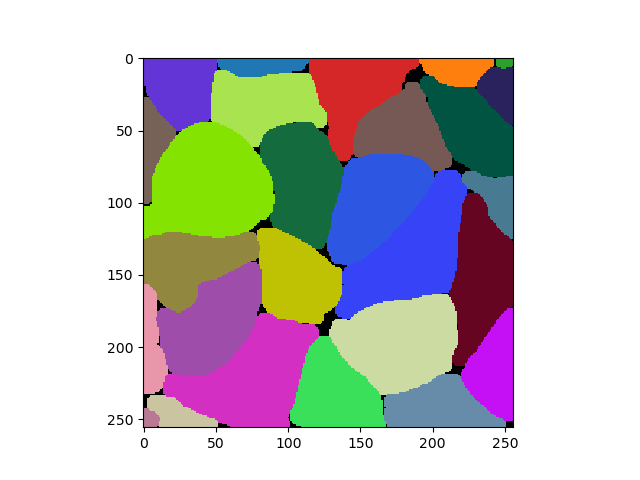

In [11]:
opened_labels = cle.opening_labels(labels, radius=5)
opened_labels

## Smoothing labels
An operation similar to label opening is label smoothing: It just prevents that black gaps are introduced. The `smooth_labels` function allows to straighten the outlines of the labels.

cl.OCLArray([[ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       [ 5,  5,  5, ...,  3,  3,  3],
       ...,
       [24, 24, 24, ..., 22, 22, 22],
       [24, 24, 24, ..., 27, 22, 22],
       [24, 24, 24, ..., 27, 27, 22]], dtype=uint32)
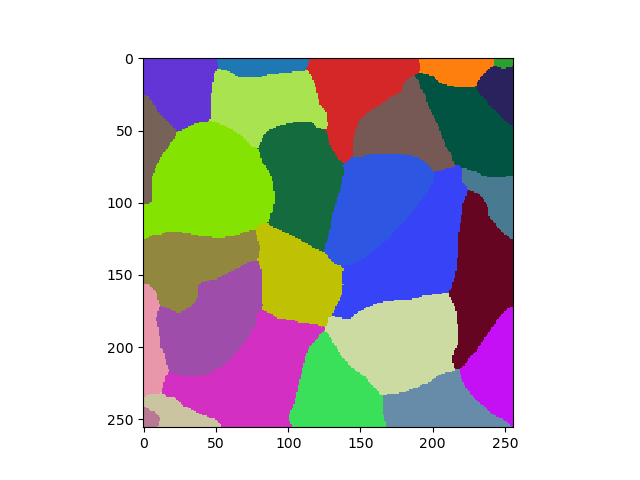

In [12]:
cle.smooth_labels(labels, radius=5)

## Exercise
Use `stackview.interact` to play with the `radius` parameter of `cle.opening_labels` and `cle.smooth_labels`. In case there is an error message, make sure that `stackview>=0.6.2` installed.

In [14]:
stackview.__version__

'0.6.1'

In [15]:
stackview.interact(cle.opening_labels, labels)

In [13]:
stackview.interact(cle.smooth_labels, labels)

## Exercise
Apply a maximum filter to the `eroded_labels` image. Try different radii. Find out why applying this function is not a good idea in practice.